# Load Data

In [8]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import lxml

In [9]:
LOWER_MEKONG_STATION_CODES =  [
    "STR", # StungTreng
    "KRA", # Kratie
    "KOM", # Kompong Cham
    "PPB", # Phnom Penh (Bassac)
    "PPP", # Phnom Penh Port
    "KOH", # Koh Khel (Bassac)
    "NEA", # Neak Luong
    "PRE", # Prek Kdam (Tonle Sap)
    "TCH", # Tan Chau
    "CDO", # Chau Doc (Bassac)
]
BASE_URL = "http://ffw.mrcmekong.org/fetchwet_st.php?StCode="
r = requests.get(BASE_URL+LOWER_MEKONG_STATION_CODES[3], verify=False)
# soup = BeautifulSoup(r.content, 'html5lib')
# body = soup.find('body')
data_string = r.content.decode('utf-8')

# Convert single quotes and remove any non-JSON parts
data_string = data_string.replace('date_gmt:', '"date_gmt":')
data_string = data_string.replace('Max:', '"Max":')
data_string = data_string.replace('Min:', '"Min":')
data_string = data_string.replace('AVG:', '"AVG":')
data_string = data_string.replace('floodLevel:', '"floodLevel":')
data_string = data_string.replace('alarmLevel:', '"alarmLevel":')
for year in range(1992, 2025):
    data_string = data_string.replace(f'{year}:', f'"{year}":')

data_string = data_string.replace(',]', ']')

# Now parse it into a list of dictionaries
data = json.loads(data_string)

# Convert to dataframe
df = pd.DataFrame(data)
df['date_gmt'] = df['date_gmt'].apply(lambda x: x.split("-")[1]+"-"+x.split("-")[2])
df['station'] = LOWER_MEKONG_STATION_CODES[3]

# Set date_gmt as index 
df.index = df['date_gmt']

df.describe()

/home/vscode/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ffw.mrcmekong.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,Max,Min,AVG,1992,1998,2000,2016,2017,2018,2019,2020,2021,2022,2023,2024,floodLevel,alarmLevel
count,153.000000,153.0,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.0,153.0
mean,9.479281,0.0,7.140654,6.269608,5.489020,9.092484,5.459869,7.036275,7.262484,4.709412,4.009477,4.709281,6.199608,5.300261,4.727124,12.0,10.5
std,1.792758,0.0,2.184002,2.262871,1.771895,1.952256,2.049587,1.856611,2.555734,2.435415,1.792308,1.689127,2.031904,2.354565,2.934124,0.0,0.0
min,4.900000,0.0,2.690000,2.040000,2.420000,4.700000,1.940000,3.550000,2.590000,1.990000,1.640000,1.760000,3.240000,0.000000,0.000000,12.0,10.5
25%,8.240000,0.0,5.290000,4.400000,4.760000,7.620000,4.150000,4.670000,4.190000,2.420000,2.270000,3.220000,3.840000,2.670000,2.120000,12.0,10.5
50%,10.390000,0.0,8.140000,6.910000,5.810000,9.760000,5.640000,8.130000,8.140000,4.070000,4.170000,4.730000,6.790000,6.280000,6.150000,12.0,10.5
75%,10.770000,0.0,9.000000,8.340000,6.870000,10.490000,7.420000,8.440000,9.600000,6.630000,5.360000,6.380000,7.840000,7.430000,7.050000,12.0,10.5
max,11.200000,0.0,9.450000,9.010000,7.920000,11.200000,8.130000,8.860000,9.950000,9.490000,7.700000,7.560000,9.220000,8.260000,9.100000,12.0,10.5


# Preprocess

<Axes: xlabel='DATE_GMT'>

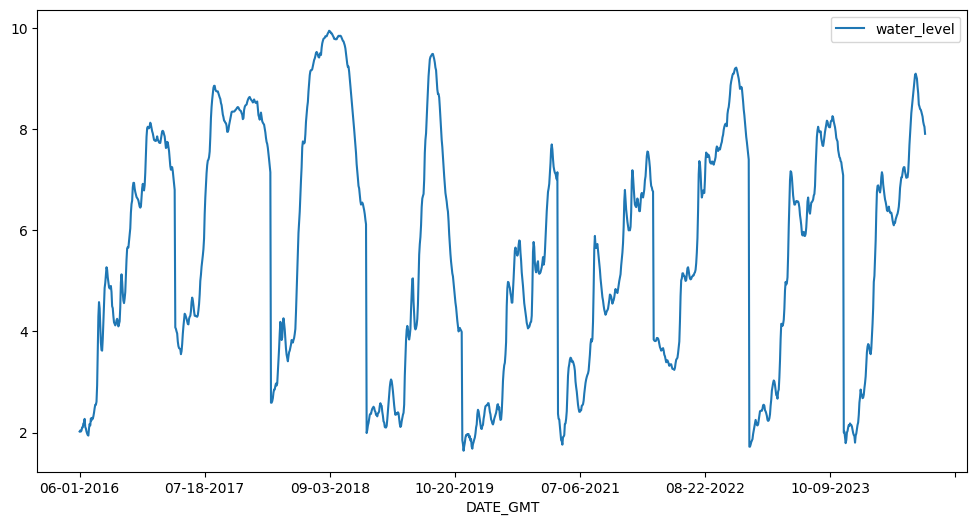

In [10]:
df_filtered = df[['date_gmt', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']]
df_filtered.set_index('date_gmt', inplace=True)
df_filtered.reset_index(inplace=True)
df_long = pd.melt(df_filtered, id_vars=['date_gmt'], value_vars=['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'],
                   var_name='Year', value_name='water_level')
df_long['DATE_GMT'] = pd.to_datetime(df_long['date_gmt'] + '-' + df_long['Year'], format='%m-%d-%Y').dt.strftime('%m-%d-%Y')
df_long = df_long[['DATE_GMT', 'water_level']]
df_non_zero = df_long[df_long['water_level'] != 0]
df_non_zero.set_index('DATE_GMT', inplace=True)
df_non_zero.index.freq='D'
df_non_zero.plot(figsize=(12,6))

# Train

In [11]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Split 2016-2024 For Training 2024-End for testing
train = df_non_zero.iloc[:1222]
test = df_non_zero.iloc[1222:]

# Scale the data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)  # Fit on train and transform both train and test
scaled_test = scaler.transform(test)

look_back = 10  # Number of previous time steps to consider for prediction
batch_size = 32  # Batch size

# Create TimeseriesGenerator for training and testing data
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=look_back, batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=look_back, batch_size=batch_size)

In [15]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, scaled_train.shape[1])))
model.add(Dense(scaled_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_generator, 
                    epochs=50, 
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1654
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038   
Epoch 16/50
38/38 ━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011      
Test Loss: 0.0013062483631074429
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


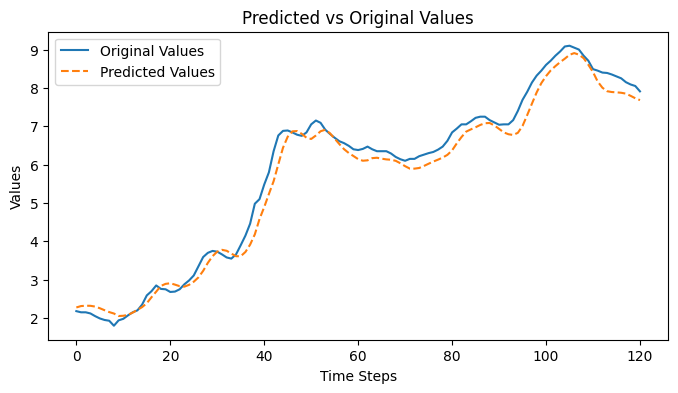

In [13]:
# Evaluate the model on test data
loss = model.evaluate(test_generator)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(test_generator)

# Inverse scale predictions to original values
predictions_inverse = scaler.inverse_transform(predictions)
test_data = scaled_test[look_back:]

# Inverse scale the predictions and test data to get back the original scale
predictions_inverse = scaler.inverse_transform(predictions)
original_test_data_inverse = scaler.inverse_transform(test_data)

# Plot predicted vs original values
plt.figure(figsize=(8, 4))
plt.plot(original_test_data_inverse, label='Original Values')
plt.plot(predictions_inverse, label='Predicted Values', linestyle='dashed')
plt.title('Predicted vs Original Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()